# B3737

In [2]:
%load_ext autoreload
%autoreload 2
%run ../draw_functions.py
%run ../kstest.py

In [3]:
from draw_functions import *
from kstest import *

In [4]:
#read csv
df = pd.read_csv('../csv/!MX22105037Y101.csv')
df['slope'] = df.groupby('ResultCurve_id').apply(lambda group: group['xvalue'].diff() / group['xtime'].diff(), include_groups=False).reset_index(level=0, drop=True)

df_02_08 = df[(df['xtime'] >= 0.2) & (df['xtime'] <= 0.8)]
df_035_065 = df[(df['xtime'] >= 0.35) & (df['xtime'] <= 0.65)]

df_035_065

,ResultCurve_id,xtime,xvalue,Batch,Sample_Code,slope
29,33282F63-02D3-452B-913A-F6FDD6ADFB71,0.356667,1.615686,100313B,L420XCA3Q,7.908950
30,33282F63-02D3-452B-913A-F6FDD6ADFB71,0.363533,1.662235,100313B,L420XCA3Q,6.779100
31,33282F63-02D3-452B-913A-F6FDD6ADFB71,0.366667,1.683477,100313B,L420XCA3Q,6.779100
32,33282F63-02D3-452B-913A-F6FDD6ADFB71,0.376667,1.751268,100313B,L420XCA3Q,6.779100
33,33282F63-02D3-452B-913A-F6FDD6ADFB71,0.406667,2.011133,100313B,L420XCA3Q,8.662184
...,...,...,...,...,...,...
13497,403FC481-DDDD-4825-B6C8-3EDE0EB28504,0.600000,2.745536,104317B,L420XCUFC,6.779100
13498,403FC481-DDDD-4825-B6C8-3EDE0EB28504,0.610000,2.835924,104317B,L420XCUFC,9.038800
13499,403FC481-DDDD-4825-B6C8-3EDE0EB28504,0.619200,2.898291,104317B,L420XCUFC,6.779100
13500,403FC481-DDDD-4825-B6C8-3EDE0EB28504,0.620000,2.903715,104317B,L420XCUFC,6.779100


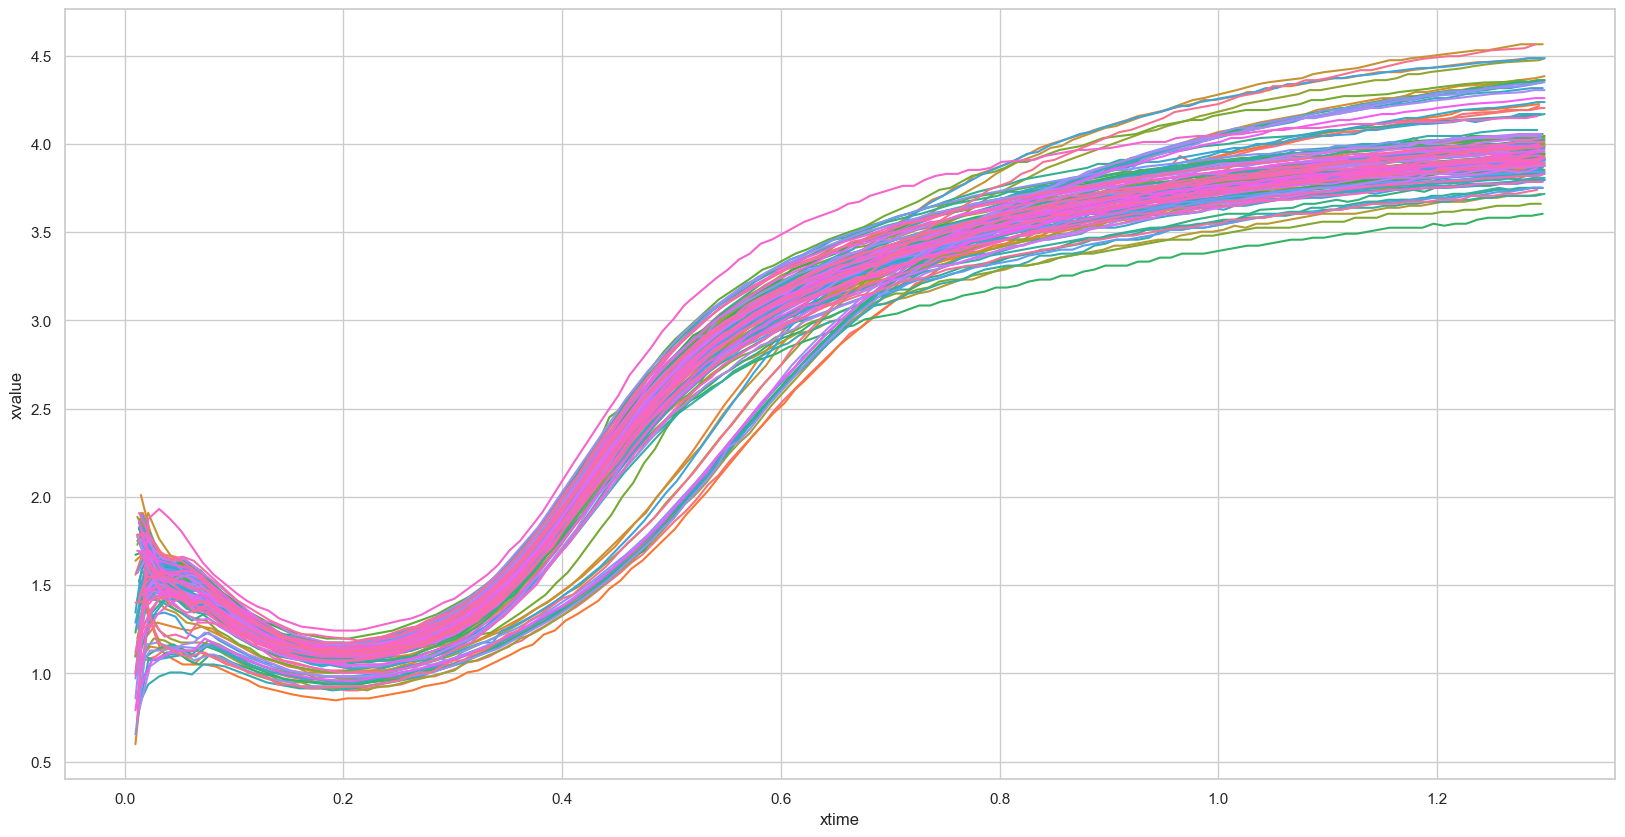

In [30]:
dessiner_commande(df)

In [55]:
from numpy import poly1d

p_slope_type = poly1d([ 5.06992478e+02, -2.34352321e+03,  4.17120817e+03, -3.52308258e+03,
                        1.37599302e+03, -1.90730246e+02,  4.03191772e+00])

ptype = poly1d([-7.78590316e+03,  6.51298582e+04, -2.39653988e+05,  5.09439020e+05,
                -6.90722825e+05,  6.22265124e+05, -3.76477466e+05,  1.51396707e+05,
                -3.93653208e+04,  6.32667001e+03, -5.69733823e+02,  2.06897277e+01,
                1.33026571e+00])

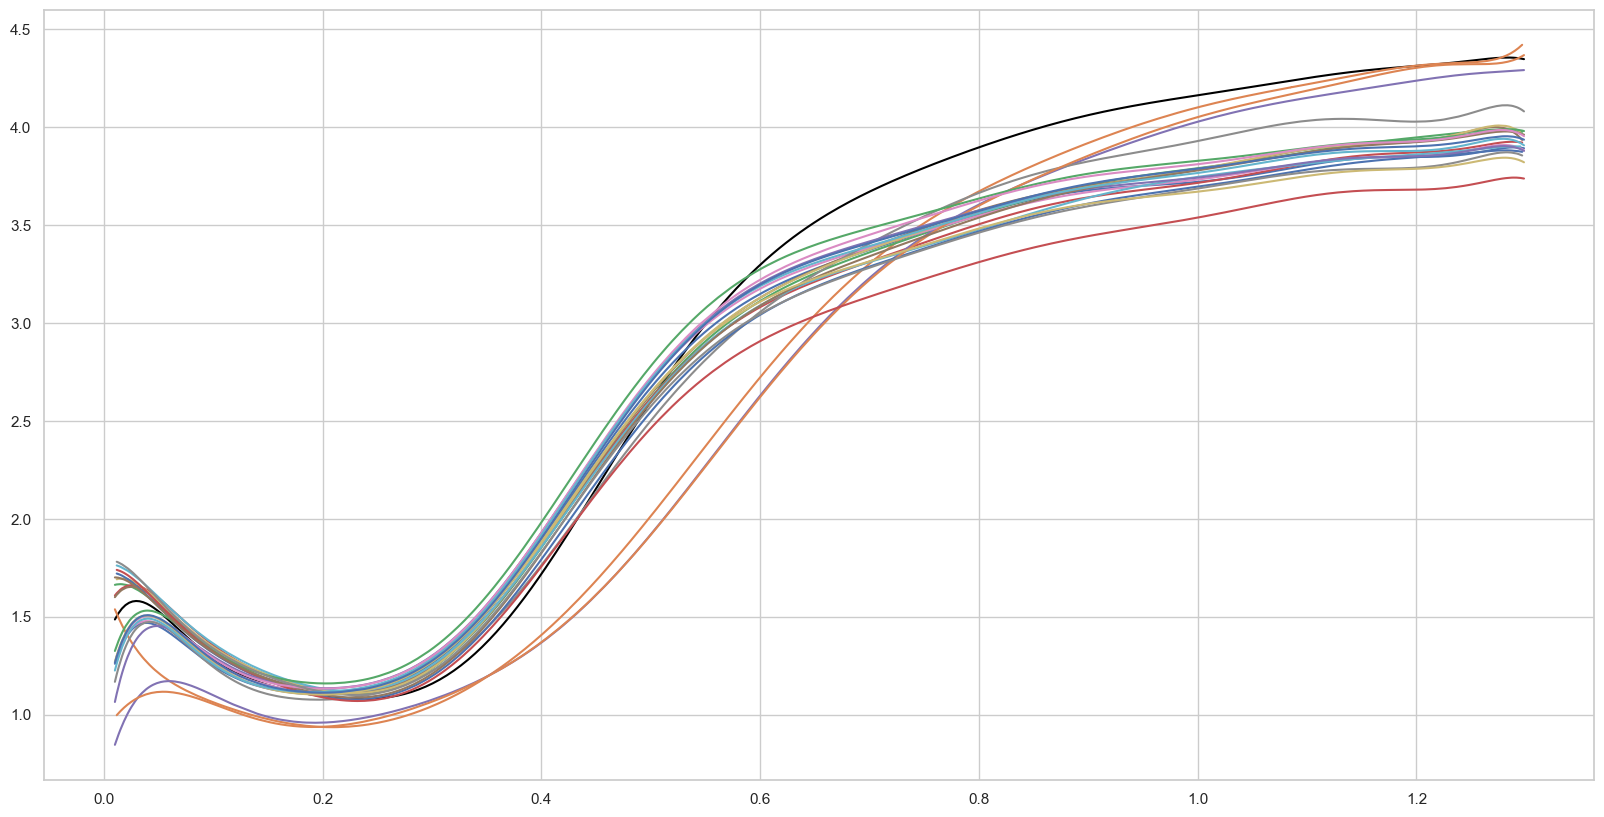

In [27]:
dessiner_commande(df, degree=12, c_type=True, ptype = ptype)

## Analyse des pentes

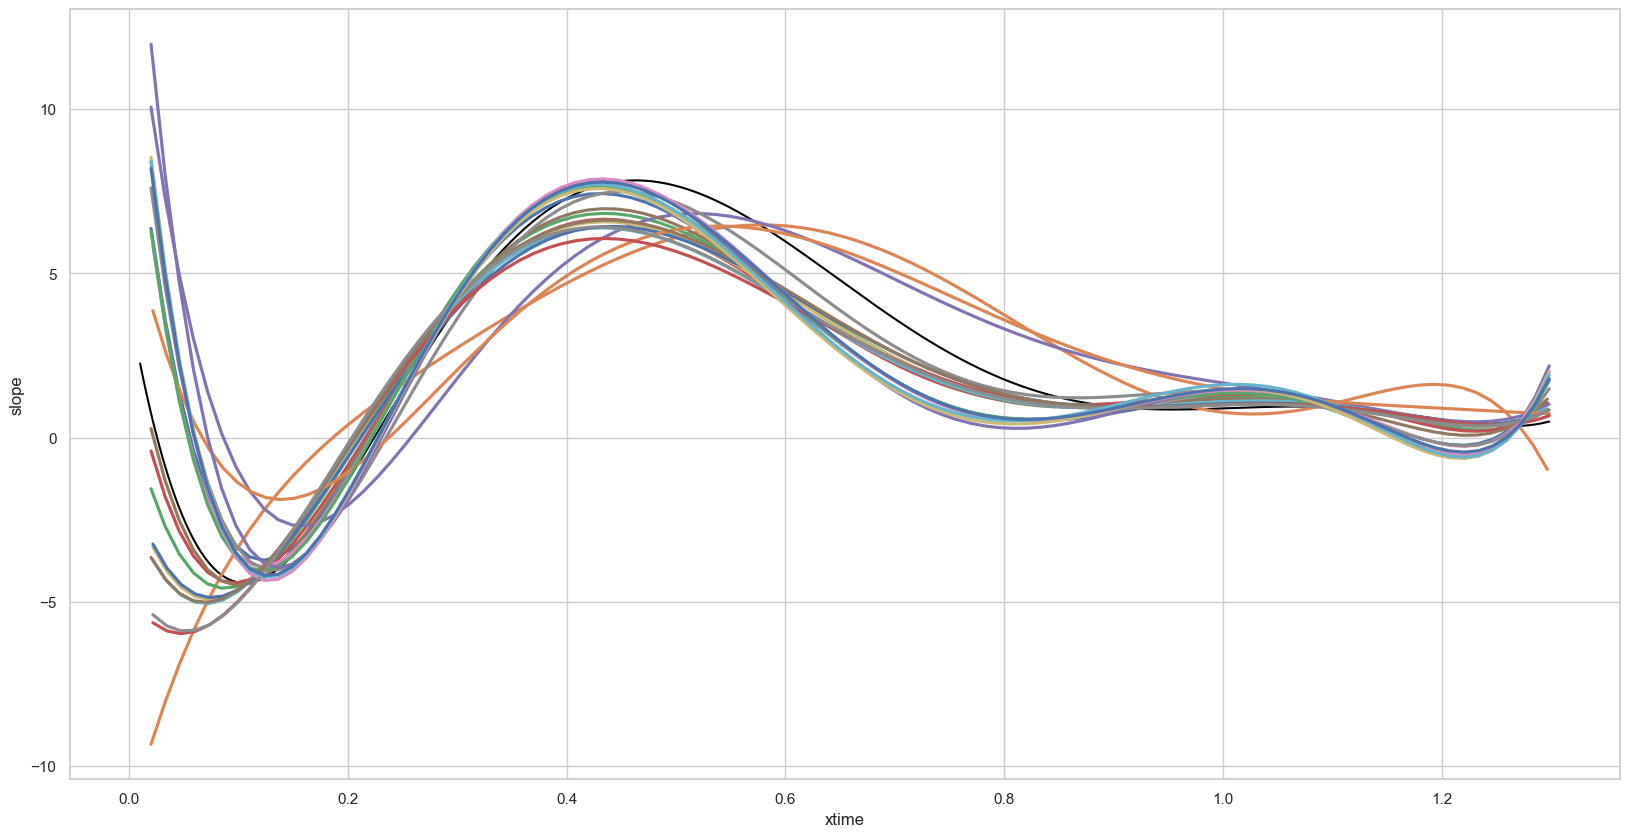

In [60]:
dessiner_commande_slope(df, 6, c_type=True, unified=True, p_slope_type=p_slope_type)

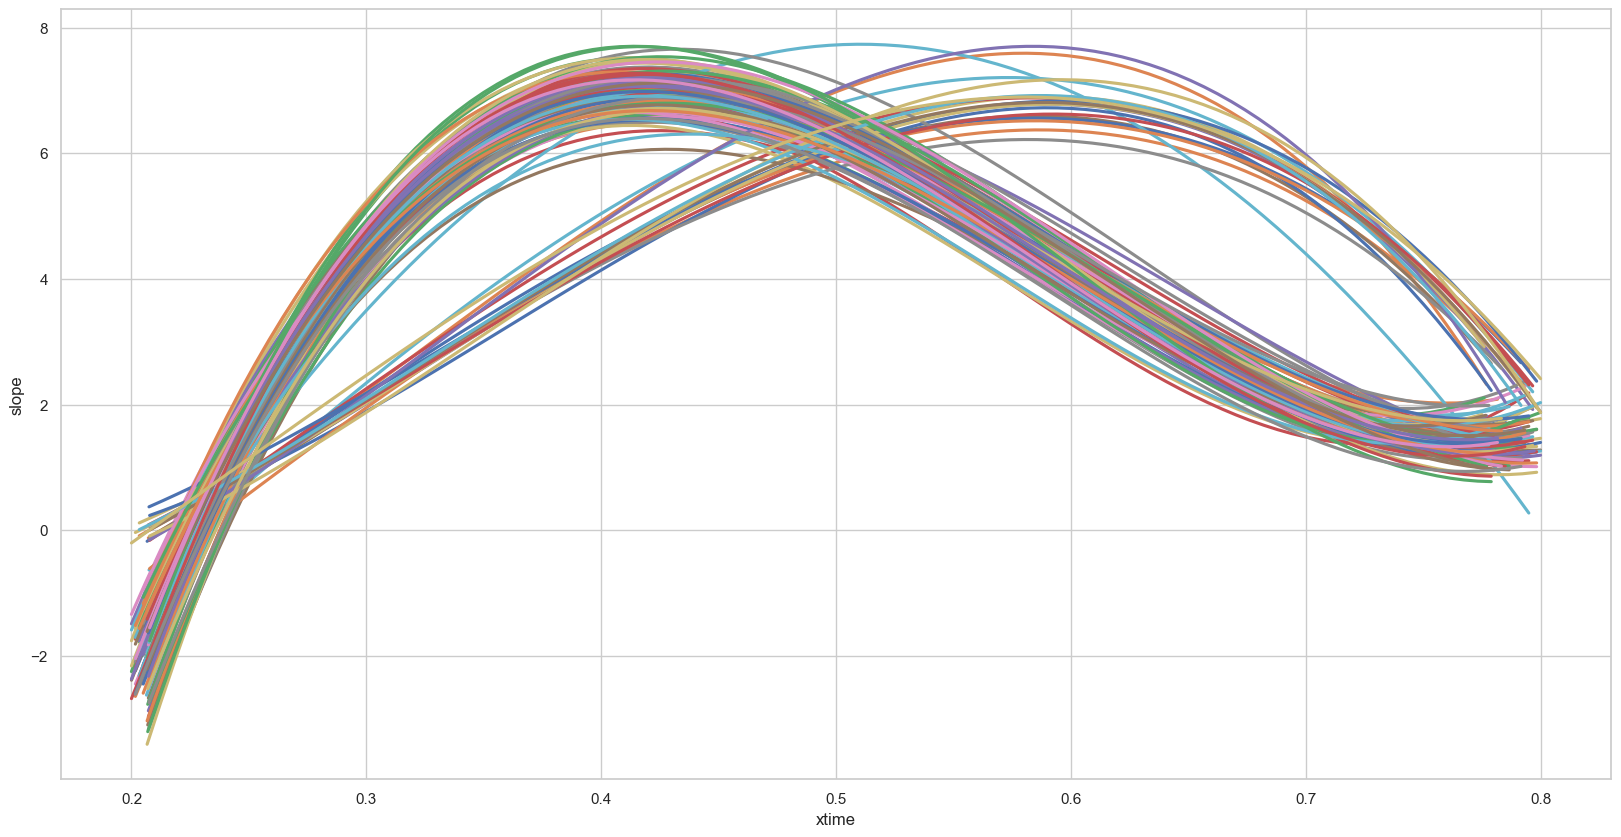

In [7]:
dessiner_commande_slope(df_02_08, 3, unified=False)

## Test Type

In [31]:
df_04_08 = df[(df['xtime'] > 0.35) & (df['xtime'] < 0.65)]
for sample in df_04_08['Sample_Code'].unique():
    df_sample = df_04_08[df_04_08['Sample_Code'] == sample]

    z1 = np.polyfit(df_sample['xtime'], df_sample['slope'], 6)
    p1 = np.poly1d(z1)

    # Update the 'fitted_slope' in df_data for the current sample
    df_04_08.loc[df_04_08['Sample_Code'] == sample, 'fitted_slope'] = p1(df_sample['xtime'])

# I want a new dataframe with three columns: OrderNo, std_dev_batch, std_dev_sample
df_std_dev = pd.DataFrame(columns=['std_dev_batch', 'std_dev_sample'])

max_slope_sample_xtime = \
df_04_08.loc[df_04_08.groupby('Sample_Code')['fitted_slope'].idxmax()][['Batch', 'xtime']].set_index('Batch')['xtime']
max_slope_batch_xtime = max_slope_sample_xtime.groupby('Batch').median()

std_dev_batch = round(np.std(max_slope_batch_xtime) * 1000, 2)
std_dev_sample = round(np.std(max_slope_sample_xtime) * 1000, 2)

df_std_dev.loc[len(df_std_dev)] = [std_dev_batch, std_dev_sample]

df_std_dev

KeyError: 'slope'

In [32]:
max_slope_sample_xtime

NameError: name 'max_slope_sample_xtime' is not defined

In [19]:
#round xtime to 2 decimal places
df['xtime'] = df['xtime'].round(2)

# Trier le DataFrame par 'xtime' puis par 'xvalue'
df_sorted = df.sort_values(['xtime', 'xvalue'])

# Grouper par 'xtime' et calculer la différence entre deux 'xvalue' consécutifs
df_sorted['xvalue_diff'] = df_sorted.groupby('xtime')['xvalue'].diff().abs()

# Grouper par 'xtime' et exclure la première et la dernière valeur
grouped = df_sorted.groupby('xtime')

# For each group, select all rows except the first and last, then calculate the max
max_diff = grouped.apply(lambda group: group.iloc[1:-1]['xvalue_diff'].max(), include_groups=False)

# Créer une nouvelle DataFrame à partir des différences maximales
df_max_diff = pd.DataFrame(max_diff).reset_index()
# Rename the unnamed column
df_max_diff = df_max_diff.rename(columns={df_max_diff.columns[1]: 'xvalue_diff'})

df_max_diff

,xtime,xvalue_diff
0,0.01,0.112985
1,0.02,0.090388
2,0.03,0.090388
3,0.04,0.135582
4,0.05,0.046098
...,...,...
125,1.26,0.067791
126,1.27,0.124284
127,1.28,0.135582
128,1.29,0.112985


<Axes: xlabel='xtime', ylabel='xvalue_diff'>

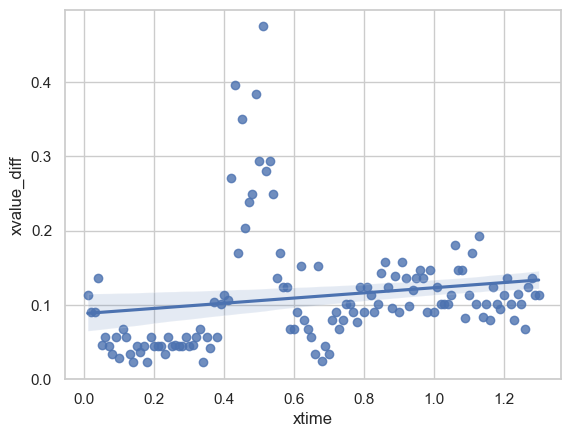

In [20]:
# Plot the max differences
sns.regplot(x='xtime', y='xvalue_diff', data=df_max_diff, scatter=True)

In [8]:
for sample in df_02_08['Sample_Code'].unique():
    df_sample = df_02_08[df_02_08['Sample_Code'] == sample]

    z1 = np.polyfit(df_sample['xtime'], df_sample['slope'], 3)
    p1 = np.poly1d(z1)

    # Update the 'fitted_slope' in df_data for the current sample
    df_02_08.loc[df_02_08['Sample_Code'] == sample, 'fitted_slope'] = p1(df_sample['xtime'])
max_slope_sample_xtime = \
df_02_08.loc[df_02_08.groupby('Sample_Code')['fitted_slope'].idxmax()][['Batch', 'xtime']].set_index('Batch')['xtime']
max_slope_sample_xtime

C:\Users\510215\AppData\Local\Temp\ipykernel_24452\2898479468.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_02_08.loc[df_02_08['Sample_Code'] == sample, 'fitted_slope'] = p1(df_sample['xtime'])


Batch
075901B    0.420000
075901B    0.426667
075901B    0.415467
075901B    0.415467
075901B    0.415467
             ...   
112321B    0.425000
112321B    0.425000
112321B    0.431667
112321B    0.441667
112321B    0.413333
Name: xtime, Length: 129, dtype: float64

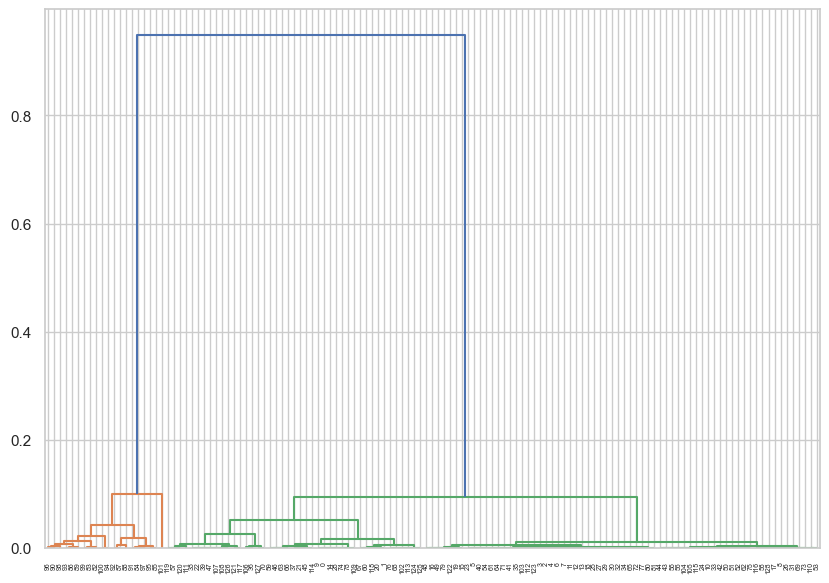

In [9]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np

# Reshape your data to a 2D array
data = np.array(max_slope_sample_xtime).reshape(-1, 1)

# Generate the links between the clusters
linked = linkage(data, 'ward')

# Create a new plot
plt.figure(figsize=(10, 7))

# Draw the dendrogram
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)

# Show the plot
plt.show()

In [11]:
from utils import (distance)

# Find the xtime corresponding to the max slope for each group

max_slope_sample_xtime = df_02_08.loc[df_02_08.groupby('Sample_Code')['fitted_slope'].idxmax()][['Batch', 'xtime']].set_index('Batch')['xtime']
dist = distance(max_slope_sample_xtime)*100

dist

74.93405841685122